# Spectral integration per bands in geo 2°bins (0-0.5, 0.5,2.5, 2.5 cpd)
- Number of spectra per 2°bins
- spectra in one bin
- map of nrj per band
- map of pourcentage of total nrj per band
- histograms of nrj per band
- histograms of pourcentage of total nrj per band


In [8]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

import drifters.utils as ut
import pynsitu as pin
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams.update({"font.size": 20})

import drifters.utils as ut
import pynsitu as pin

from GDP_lib import noise_traj, negpos_spectra

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

<Client: 'tcp://10.148.0.98:46765' processes=0 threads=0, memory=0 B>

In [9]:
def geo_plot(d_array, title="", legend="", **kwargs):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    d_array.rename(legend).plot(
        x="lon_bins", y="lat_bins", **kwargs, ax=ax, transform=ccrs.PlateCarree()
    )
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    ax.set_title(title)
    gl = ax.gridlines(
        draw_labels=True,
    )

# LOAD

In [4]:
root_dir = "/home1/datawork/mdemol/GDP"
"""
key2 = ""
zarr_argos = os.path.join(root_dir, "argos_geospectra_2" + key2 + ".zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsa = xr.open_zarr(zarr_argos).persist()
"""

key2 = "_corrected"
zarr_argos = os.path.join(root_dir, "argos_geospectra_2" + key2 + ".zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsgc = xr.open_zarr(zarr_gps)
dsac = xr.open_zarr(zarr_argos)
g = dsgc.nb_geobins
a = dsac.nb_geobins
neg, pos = negpos_spectra(dsgc.drop_vars("nb_geobins"))
dsgc = (neg + pos).persist()
neg, pos = negpos_spectra(dsac.drop_vars("nb_geobins"))
dsac = (neg + pos).persist()
dsgc["nb_geobins"] = g
dsac["nb_geobins"] = a

In [5]:
dsgc

<xarray.Dataset>
Dimensions:        (frequency: 720, lat_bins: 90, lon_bins: 180)
Coordinates:
  * frequency      (frequency) float64 -0.0 0.01667 0.03333 ... 11.97 11.98
  * lat_bins       (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins       (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables: (12/13)
    E_aen          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_avxy         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_axy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlat   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlatm  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_vevn     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    ...             ...
    E_venw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxydiff      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxyw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_xy           (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    nb_geobins     (lon_bins, lat_bins) int64 dask.array<chunksize=(180, 90), meta=np.ndarray>

_______
# Number of spectra per bins

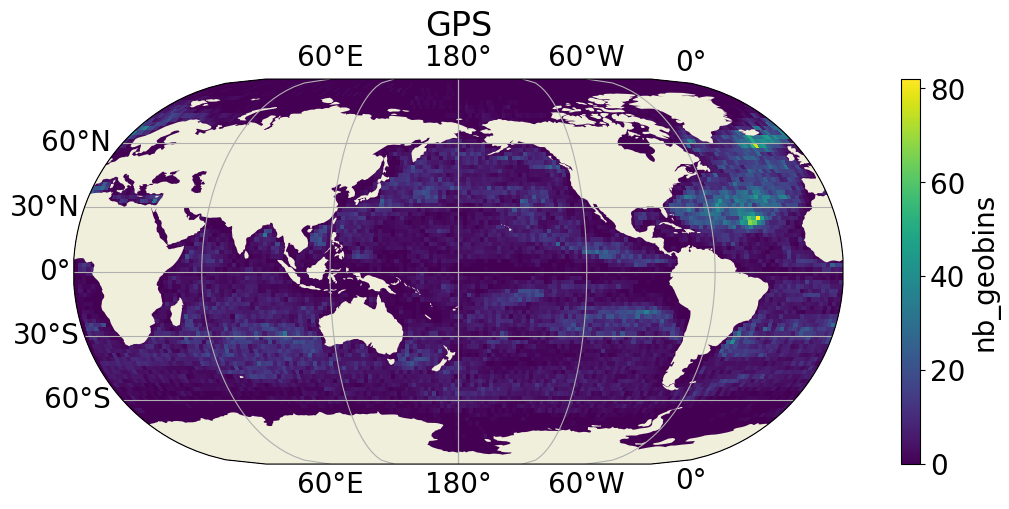

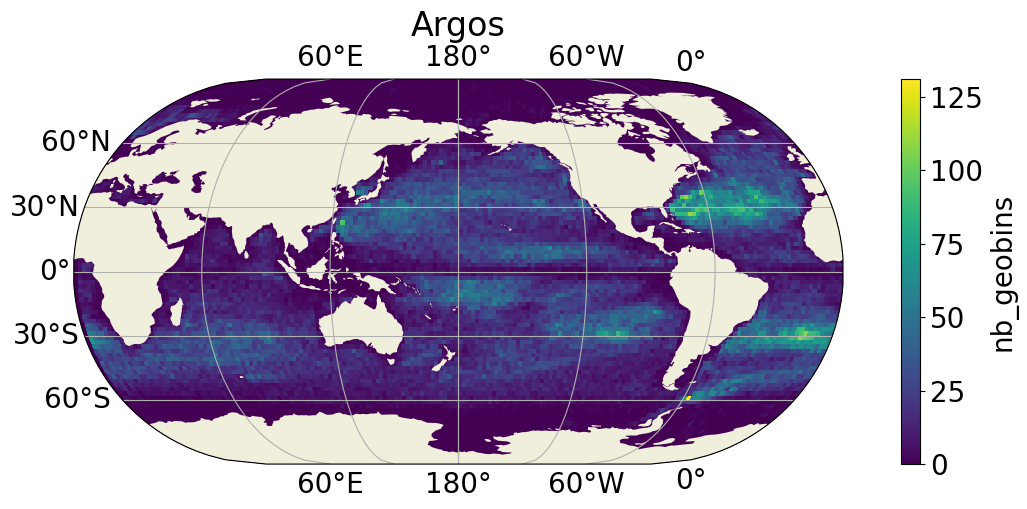

In [10]:
# nb counts
geo_plot(dsgc.nb_geobins, legend="nb of points/bins", title="GPS")
geo_plot(dsac.nb_geobins, legend="nb of points/bins", title="Argos")

_______
# Spectra in one bin

Text(0.5, 0.98, 'lon=-40, lat=30')

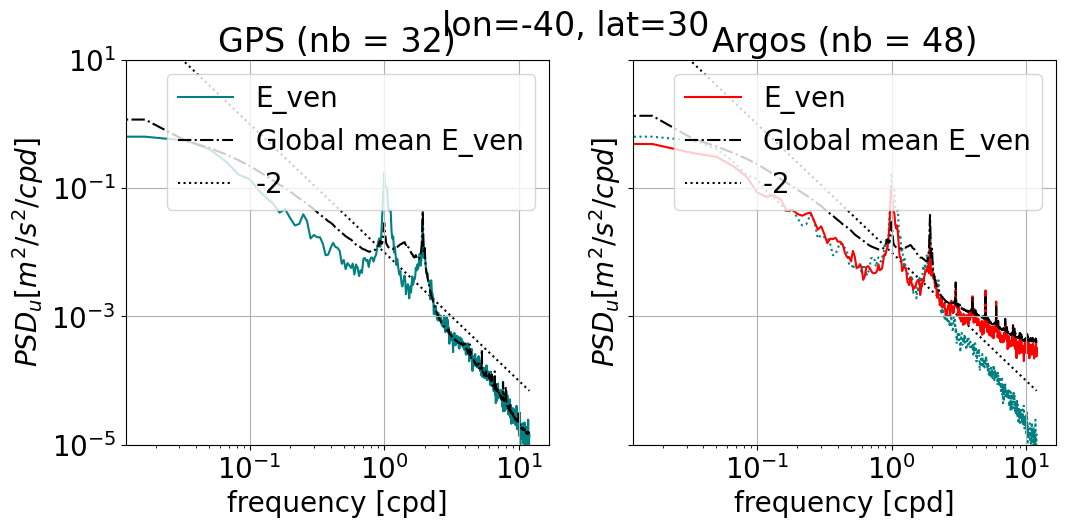

In [11]:
# CHOOSE BIN HERE
lon = -40
lat = 30


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
ax = ax.flatten()

dsgc.E_ven.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label="E_ven", color="teal", ax=ax[0], zorder=1
)
dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="Global mean E_ven", color="k", ls="-.", ax=ax[0], zorder=1
)

dsgc.E_ven.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    ls=":", color="teal", ax=ax[1], zorder=1
)

dsac.E_ven.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label="E_ven", color="red", ax=ax[1], zorder=1
)
dsac.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="Global mean E_ven", color="k", ls="-.", ax=ax[1], zorder=1
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / dsac.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color="k", zorder=0)
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls=":", color = 'grey')
    a.set_ylim((1e-5, 1e1))
    a.set_ylabel(r"$PSD_u [m^2/s^2/cpd]$")
    a.legend()

ax[0].set_title(
    f"GPS (nb = {int(dsgc.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})"
)
ax[1].set_title(
    f"Argos (nb = {int(dsac.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})"
)

fig.suptitle(f"lon={lon}, lat={lat}")

Text(0.5, 0.98, 'lon=-40, lat=30')

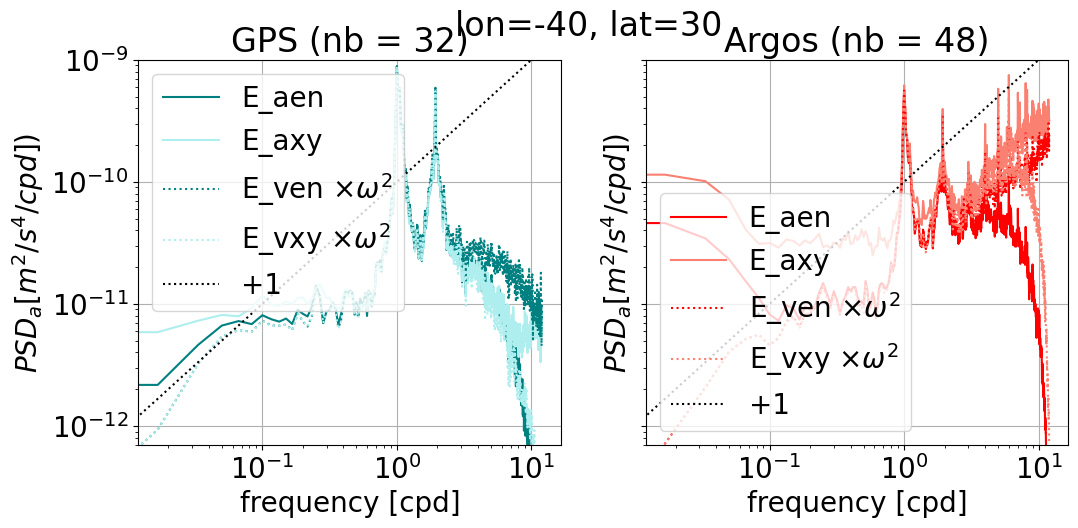

In [12]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
ax = ax.flatten()

dsgc.E_aen.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label="E_aen", color="teal", ax=ax[0]
)
dsgc.E_axy.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label="E_axy", color="paleturquoise", ax=ax[0]
)
# dsgc.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_avxy", color="b", ax=ax[0])
dsgc.E_venw2.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label=r"E_ven $ \times \omega^2$", color="teal", ls=":", ax=ax[0]
)
dsgc.E_vxyw2.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label=r"E_vxy $ \times \omega^2$", color="paleturquoise", ls=":", ax=ax[0]
)

dsac.E_aen.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label="E_aen", color="red", ax=ax[1]
)
dsac.E_axy.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label="E_axy", color="salmon", ax=ax[1]
)
# dsac.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="teal", ax=ax[1])
dsac.E_venw2.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[1]
)
dsac.E_vxyw2.sel(lon_bins=lon, lat_bins=lat, method="nearest").plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[1]
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (dsac.frequency.isel(frequency=slice(0, 725)) * 1e-10).plot(
        ax=a, label="+1", ls=":", color="k"
    )
    # (dsac.frequency.isel(frequency= slice(0,725))**0 * 1e-10).plot(ax=a, label="+1", ls=":", color='k')
    # (dsac.frequency**4 * 1e-9).plot(ax=a, label="+4", ls="--")
    a.legend()
    a.set_ylim(7 * 1e-13, 1e-9)
    a.set_ylabel(r"$PSD_a [m^2/s^4/cpd]$)")
ax[0].set_title(
    f"GPS (nb = {int(dsgc.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})"
)
ax[1].set_title(
    f"Argos (nb = {int(dsac.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})"
)

fig.suptitle(f"lon={lon}, lat={lat}")

_______
# Integration per band

In [13]:
def var_per_band(ds, fmin, fmax):
    return ds.where(
        (ds.frequency >= fmin) & (dsgc.frequency < fmax), drop=True
    ).integrate(
        "frequency"
    )  # |(ds.frequency<= -fmin) & (dsgc.frequency> -fmax), drop=True).integrate('frequency')


l = [i for i in dsgc if "E_" in i]
for i in l:
    dsgc[i.replace("E_", "BF_")] = var_per_band(dsgc, 0, 0.5)[i]
    dsgc[i.replace("E_", "inertial_")] = var_per_band(dsgc, 0.5, 2.5)[i]
    dsgc[i.replace("E_", "HF_")] = var_per_band(dsgc, 2.5, 12.5)[i]
    dsgc[i.replace("E_", "total_")] = dsgc[i].integrate("frequency")
for i in l:
    dsac[i.replace("E_", "BF_")] = var_per_band(dsac, 0, 0.5)[i]
    dsac[i.replace("E_", "inertial_")] = var_per_band(dsac, 0.5, 2.5)[i]
    dsac[i.replace("E_", "HF_")] = var_per_band(dsac, 2.5, 12.5)[i]
    dsac[i.replace("E_", "total_")] = dsgc[i].integrate("frequency")

In [11]:
dsac

<xarray.Dataset>
Dimensions:               (frequency: 720, lat_bins: 90, lon_bins: 180)
Coordinates:
  * frequency             (frequency) float64 -0.0 0.01667 ... 11.97 11.98
  * lat_bins              (lat_bins) float64 -89.0 -87.0 -85.0 ... 87.0 89.0
  * lon_bins              (lon_bins) float64 -179.0 -177.0 ... 177.0 179.0
Data variables: (12/49)
    E_aen                 (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_avxy                (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_axy                 (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlat          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlatm         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_vevn            (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    ...                    ...
    BF_vxyw2              (lon_bins, lat_bins) float64 dask.array<chunksize=(23, 23), meta=np.ndarray>
    inertial_vxyw2        (lon_bins, lat_bins) float64 dask.array<chunksize=(23, 23), meta=np.ndarray>
    HF_vxyw2              (lon_bins, lat_bins) float64 dask.array<chunksize=(23, 23), meta=np.ndarray>
    BF_xy                 (lon_bins, lat_bins) float64 dask.array<chunksize=(23, 23), meta=np.ndarray>
    inertial_xy           (lon_bins, lat_bins) float64 dask.array<chunksize=(23, 23), meta=np.ndarray>
    HF_xy                 (lon_bins, lat_bins) float64 dask.array<chunksize=(23, 23), meta=np.ndarray>

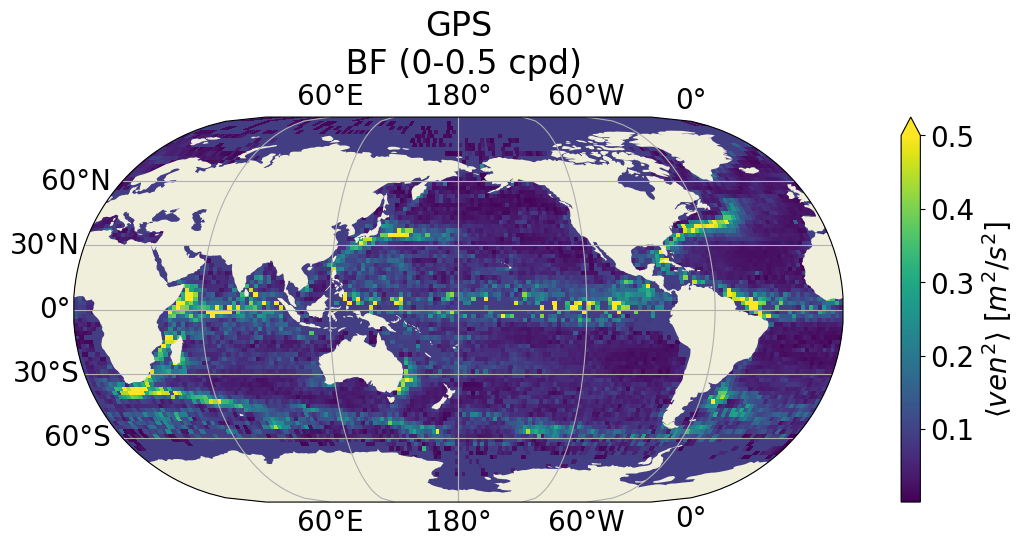

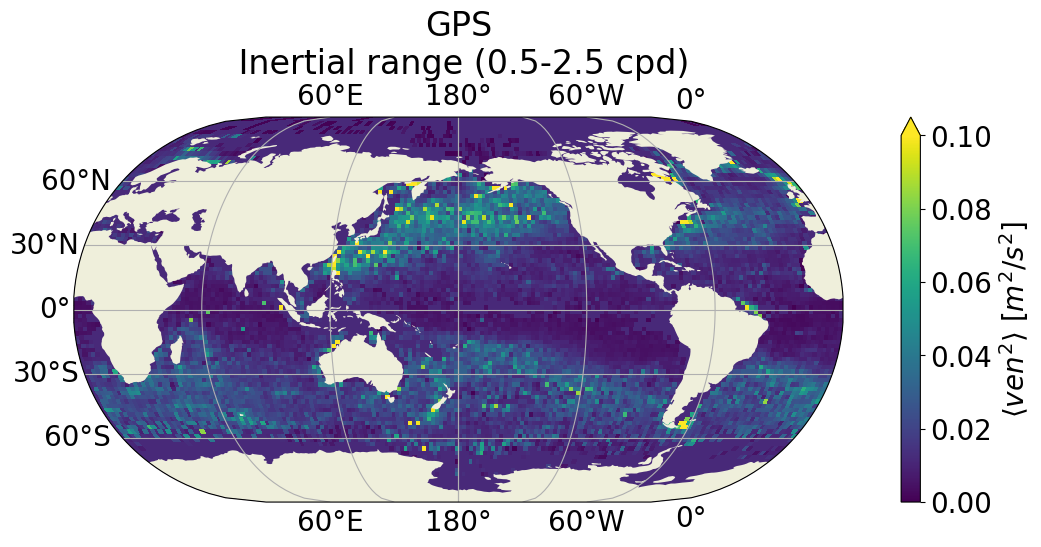

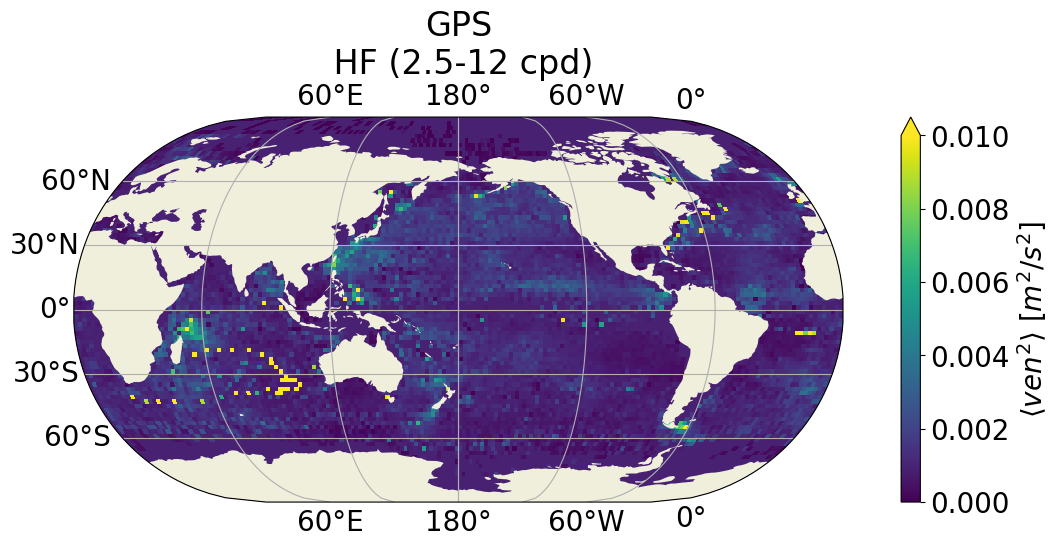

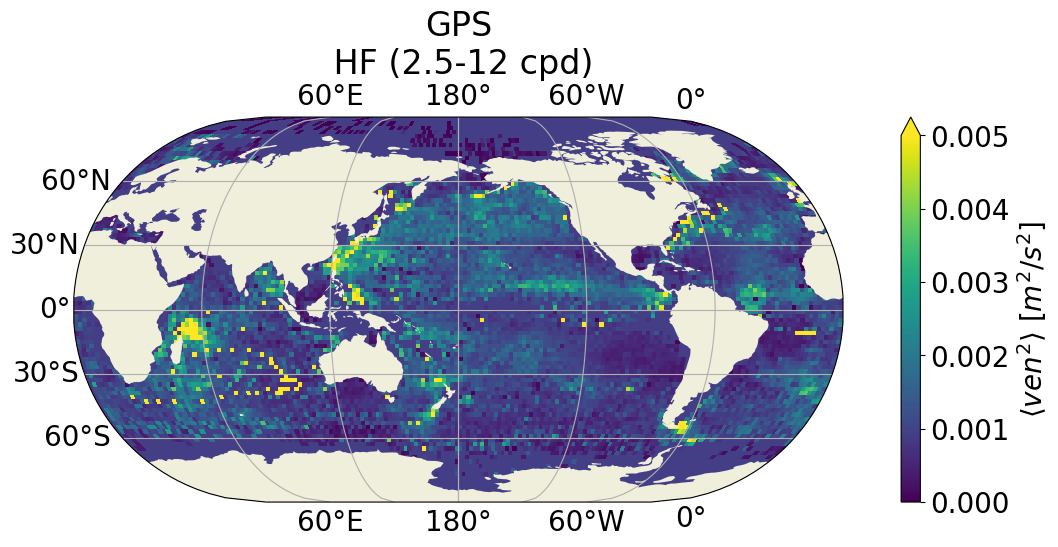

In [14]:
geo_plot(
    dsgc.BF_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="GPS\n BF (0-0.5 cpd)",
    cmap="viridis",
    vmax=0.5,
)
geo_plot(
    dsgc.inertial_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="GPS\n Inertial range (0.5-2.5 cpd)",
    cmap="viridis",
    vmax=0.1,
)
geo_plot(
    dsgc.HF_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="GPS\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=0.01,
)

geo_plot(
    dsgc.HF_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="GPS\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=0.005,
)

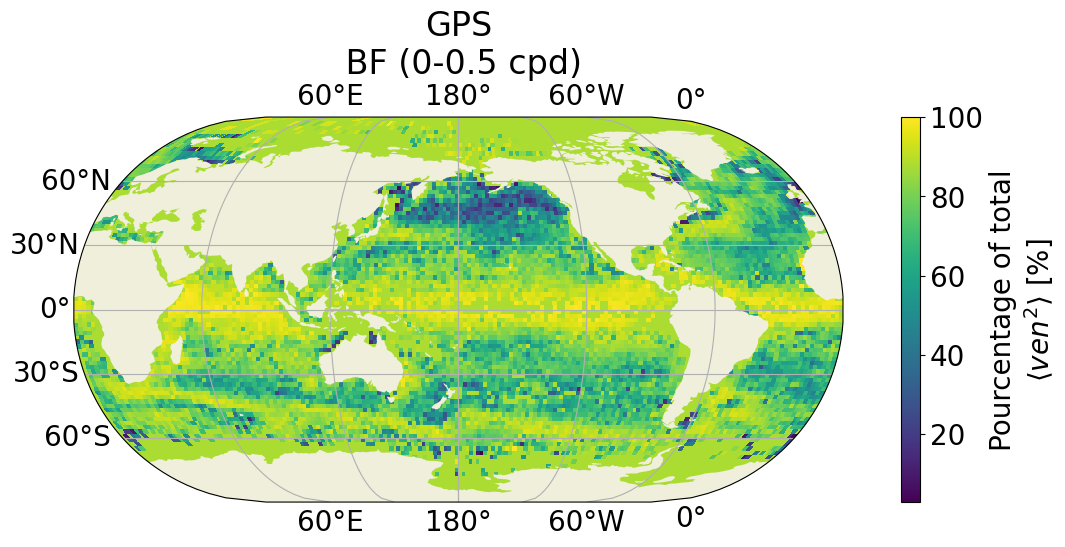

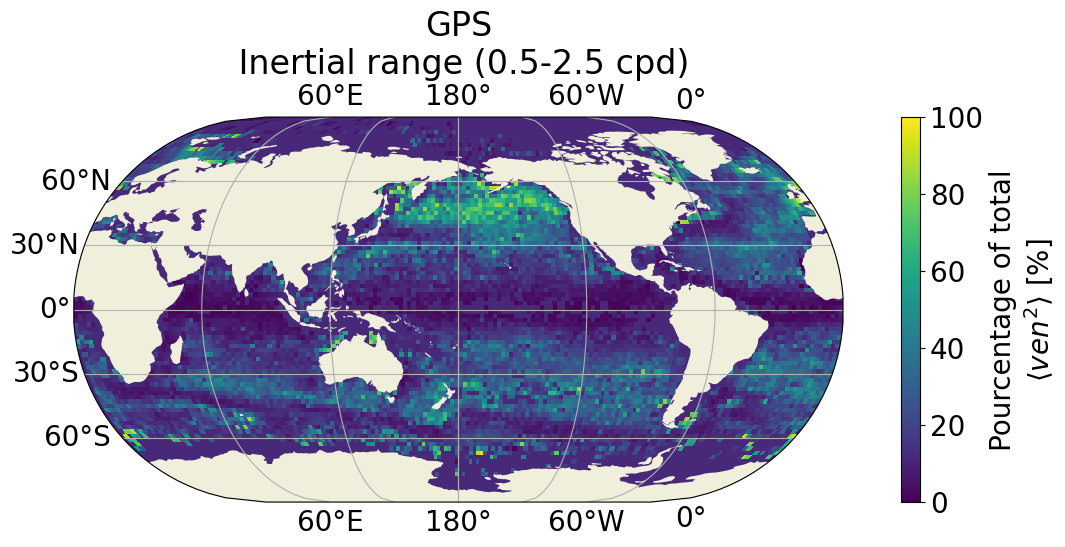

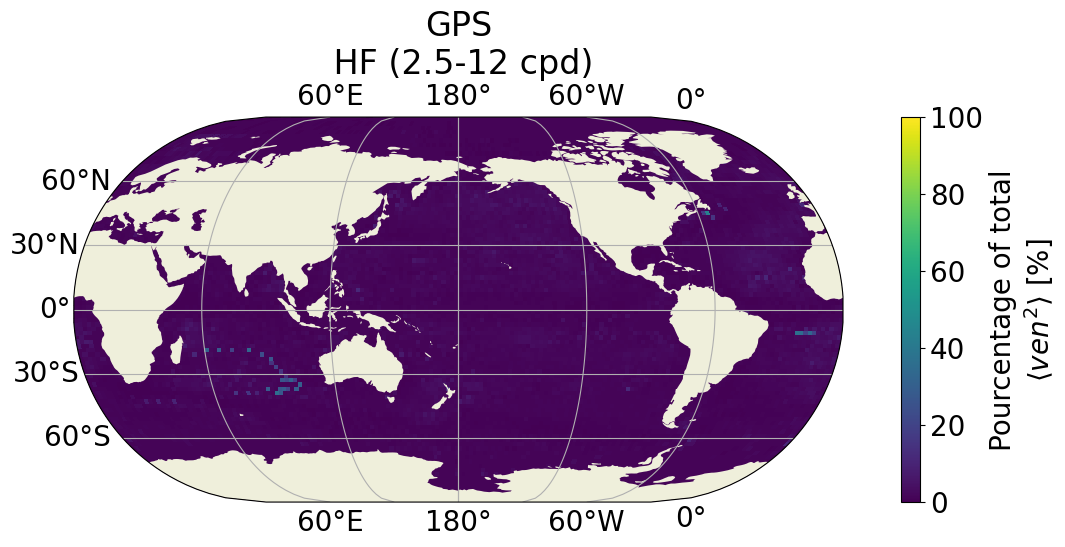

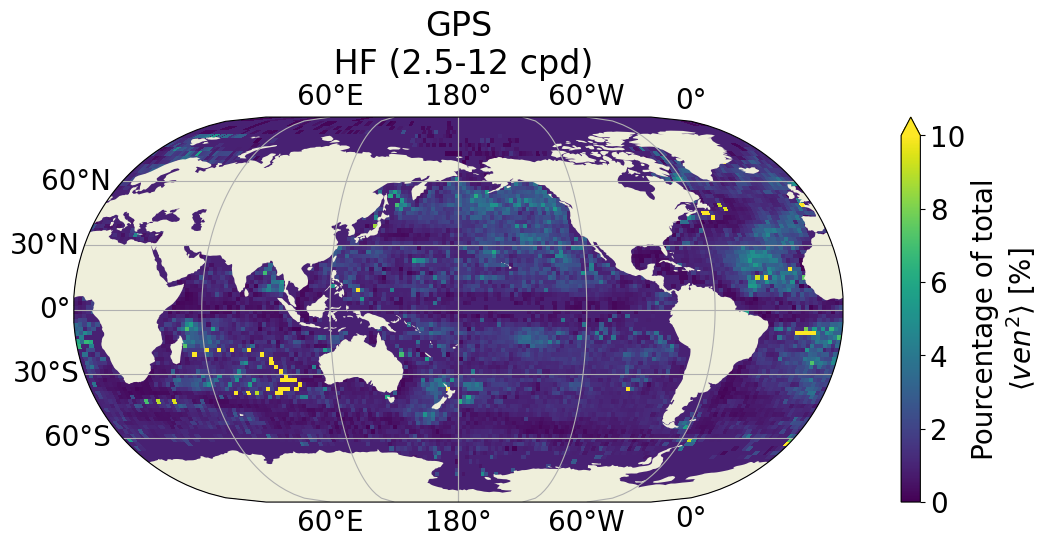

In [33]:
geo_plot(
    dsgc.BF_ven / dsgc.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="GPS\n BF (0-0.5 cpd)",
    cmap="viridis",
    vmax=100,
)
geo_plot(
    dsgc.inertial_ven / dsgc.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="GPS\n Inertial range (0.5-2.5 cpd)",
    cmap="viridis",
    vmax=100,
)
geo_plot(
    dsgc.HF_ven / dsgc.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="GPS\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=100,
)
geo_plot(
    dsgc.HF_ven / dsgc.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="GPS\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=10,
)

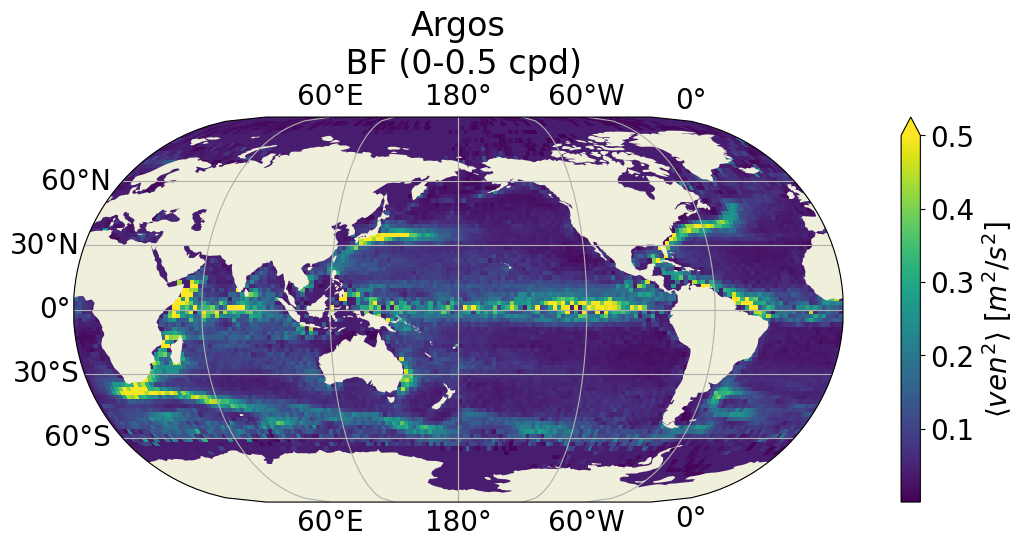

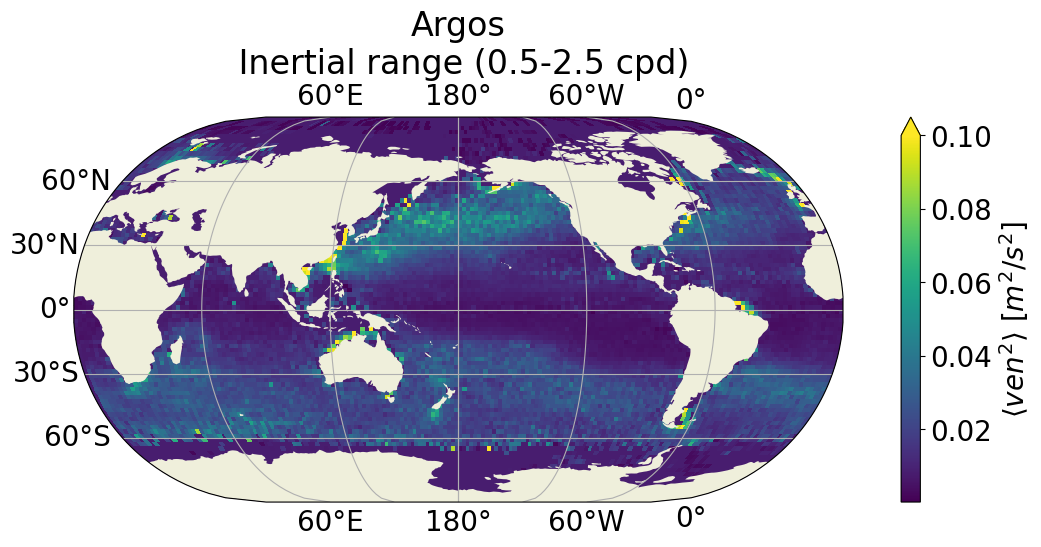

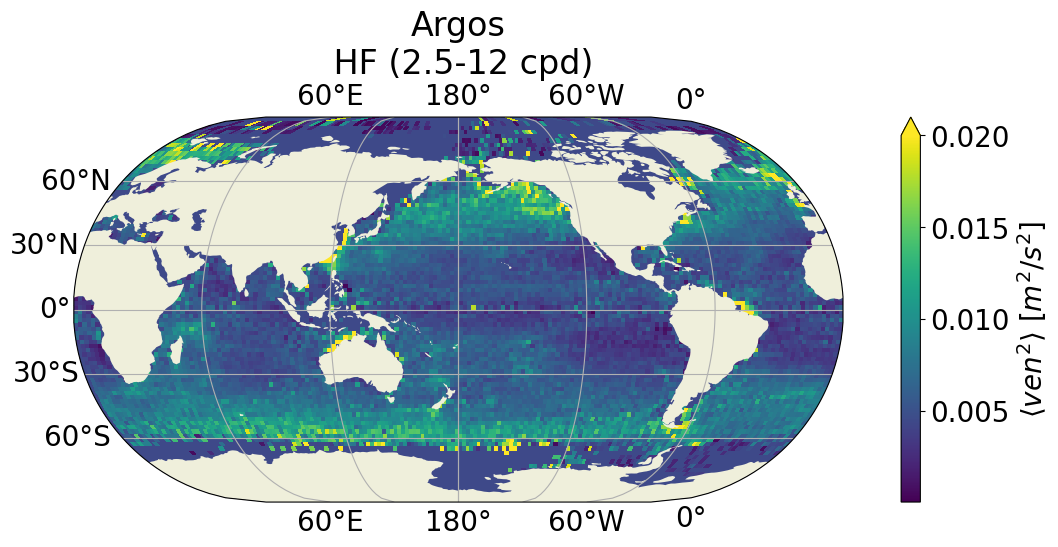

In [20]:
geo_plot(
    dsac.BF_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="Argos\n BF (0-0.5 cpd)",
    cmap="viridis",
    vmax=0.5,
)
geo_plot(
    dsac.inertial_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="Argos\n Inertial range (0.5-2.5 cpd)",
    cmap="viridis",
    vmax=0.1,
)
geo_plot(
    dsac.HF_ven,
    legend=r"$ \langle ven^2 \rangle $ [$m^2/s^2$]",
    title="Argos\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=0.02,
)

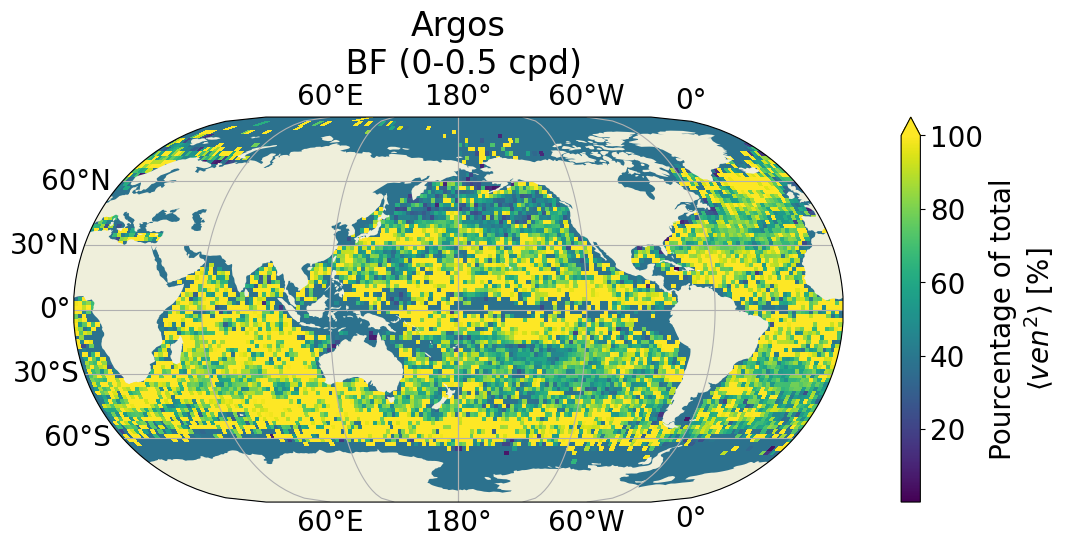

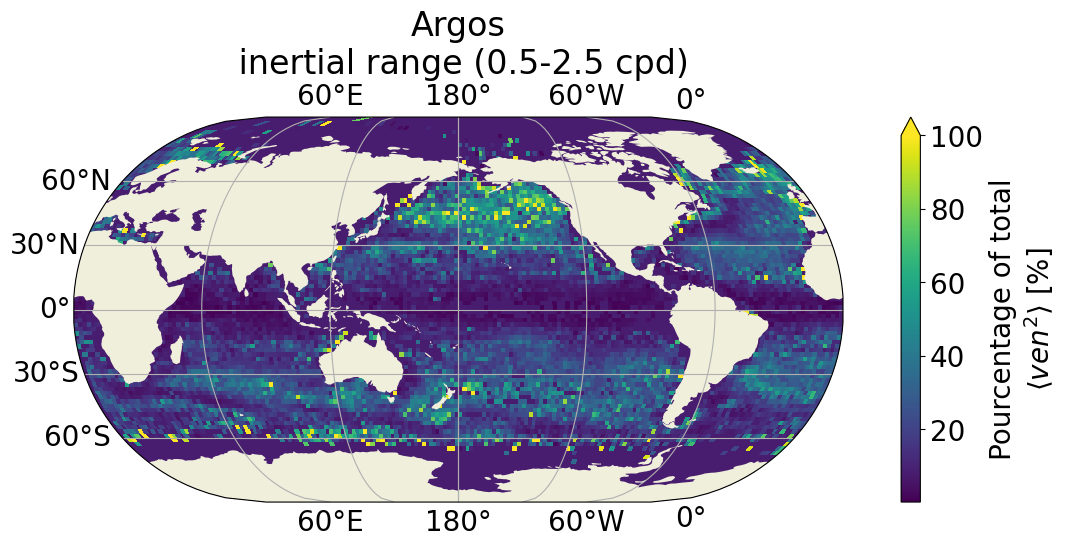

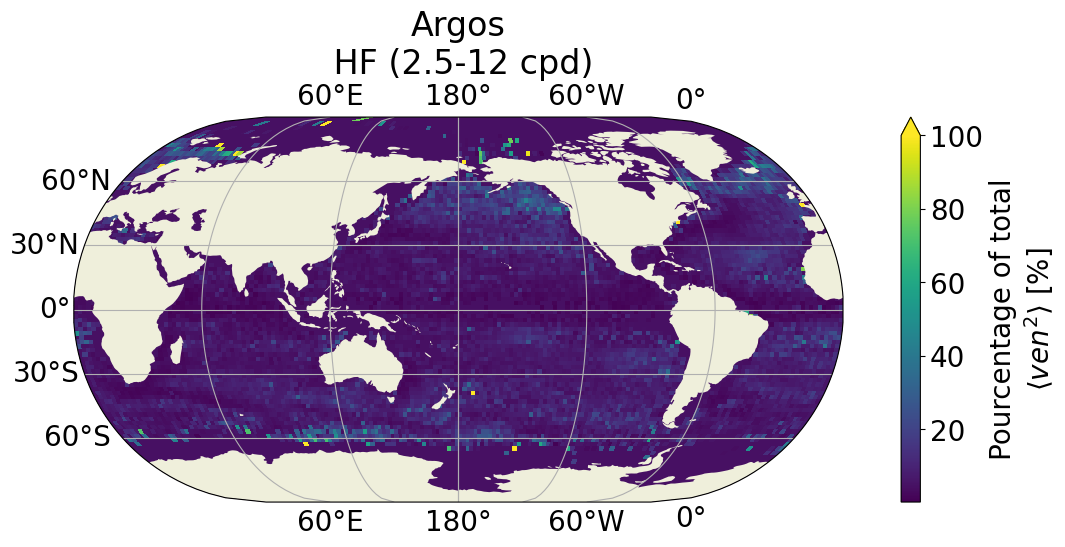

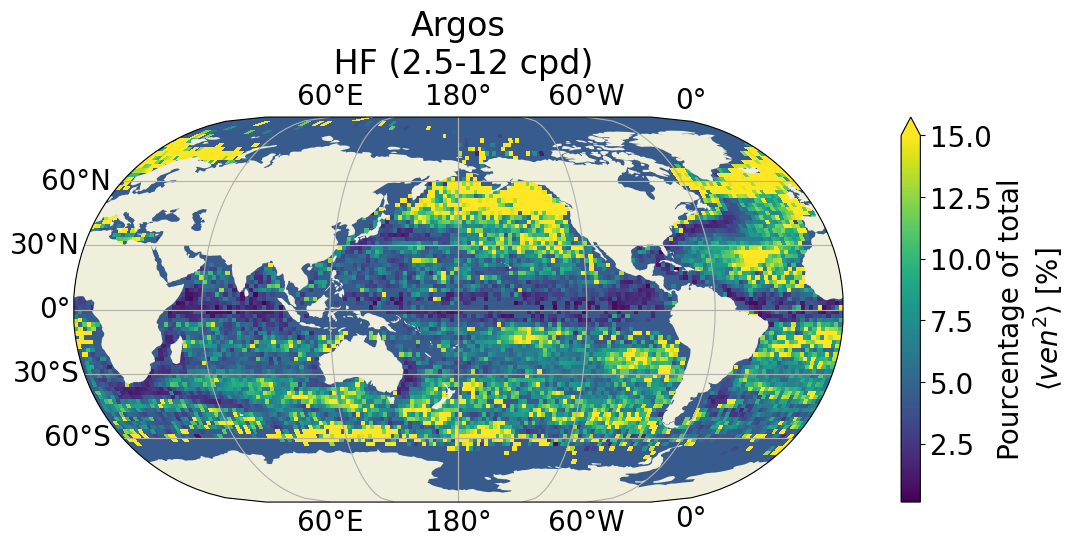

In [34]:
geo_plot(
    dsac.BF_ven / dsac.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="Argos\n BF (0-0.5 cpd)",
    cmap="viridis",
    vmax=100,
)
geo_plot(
    dsac.inertial_ven / dsac.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="Argos\n inertial range (0.5-2.5 cpd)",
    cmap="viridis",
    vmax=100,
)
geo_plot(
    dsac.HF_ven / dsac.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="Argos\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=100,
)
geo_plot(
    dsac.HF_ven / dsac.total_ven * 100,
    legend="Pourcentage of total \n " + r"$\langle ven^2 \rangle $ [%]",
    title="Argos\n HF (2.5-12 cpd)",
    cmap="viridis",
    vmax=15,
)

____
# Histograms

In [22]:
dsgc.BF_ven.min().compute()

<xarray.DataArray 'BF_ven' ()>
array(0.0003127)

In [23]:
def plot_histogram(darray, ax, bins=np.linspace(-2, 2, 100), density=True, **kwargs):
    h, b = da.histogram(darray, bins=bins, density=density)
    ax.plot(bins[:-1] + np.diff(bins) / 2, h, **kwargs)

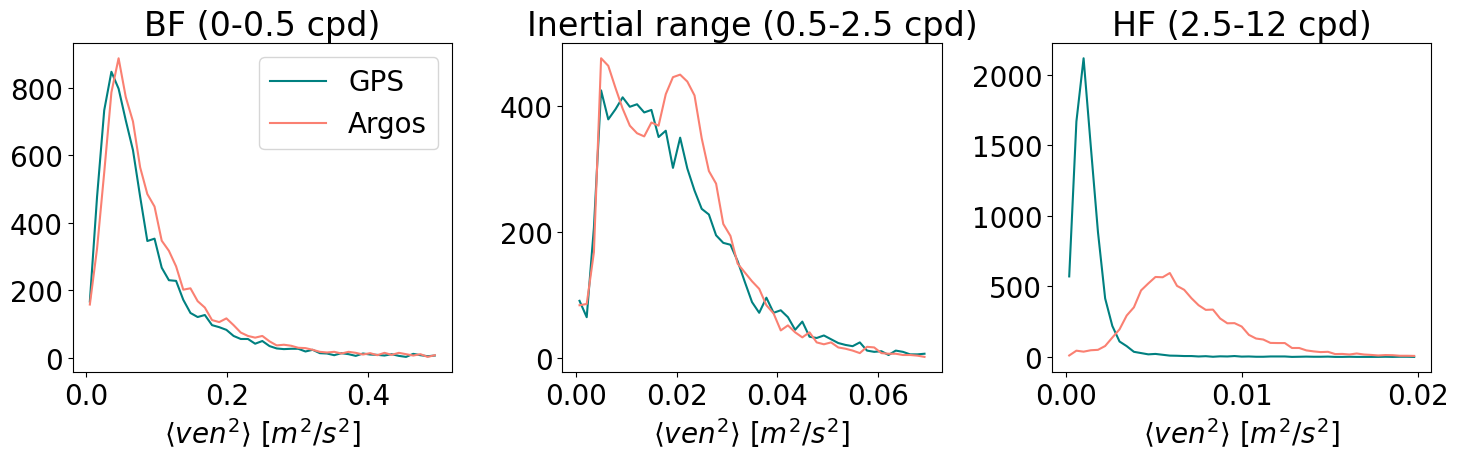

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
plot_histogram(
    dsgc.BF_ven,
    bins=np.linspace(0, 0.5, 50),
    ax=axs[0],
    density=False,
    label="GPS",
    color="teal",
)
plot_histogram(
    dsac.BF_ven,
    bins=np.linspace(0, 0.5, 50),
    ax=axs[0],
    density=False,
    label="Argos",
    color="salmon",
)
plot_histogram(
    dsgc.inertial_ven,
    bins=np.linspace(0, 0.07, 50),
    ax=axs[1],
    density=False,
    color="teal",
)
plot_histogram(
    dsac.inertial_ven,
    bins=np.linspace(0, 0.07, 50),
    ax=axs[1],
    density=False,
    color="salmon",
)
plot_histogram(
    dsgc.HF_ven, bins=np.linspace(0, 0.02, 50), ax=axs[2], density=False, color="teal"
)
plot_histogram(
    dsac.HF_ven, bins=np.linspace(0, 0.02, 50), ax=axs[2], density=False, color="salmon"
)
for a in axs:
    a.set_xlabel(r"$ \langle ven^2 \rangle $ [$m^2/s^2$]")
axs[0].set_title("BF (0-0.5 cpd)")
axs[1].set_title("Inertial range (0.5-2.5 cpd)")
axs[2].set_title("HF (2.5-12 cpd)")

axs[0].legend()

fig.tight_layout()

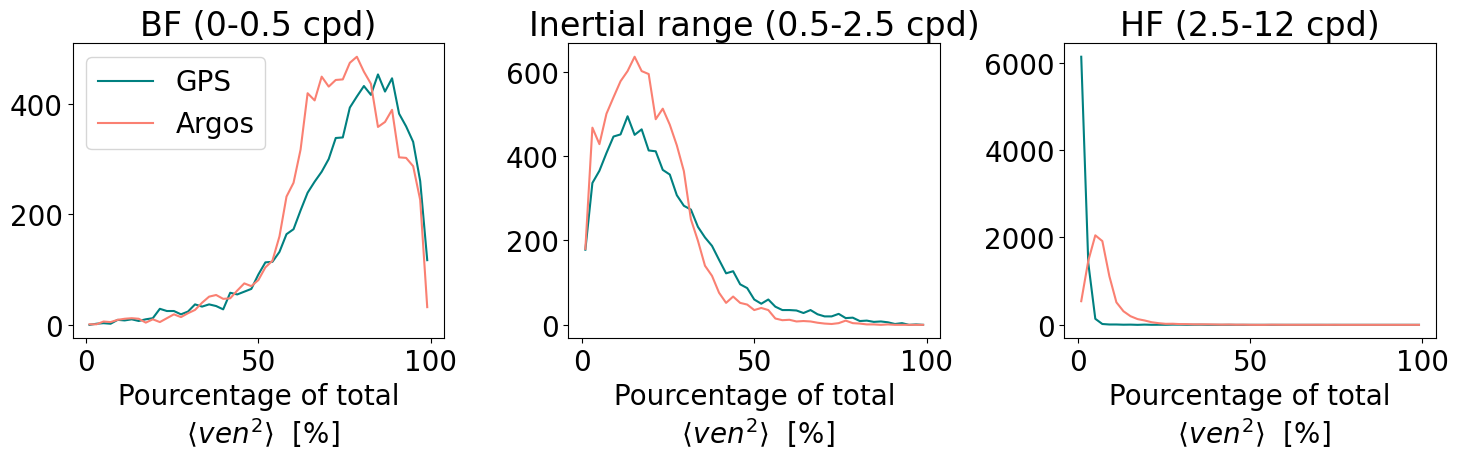

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
plot_histogram(
    dsgc.BF_ven / dsgc.E_ven.integrate("frequency") * 100,
    bins=np.linspace(0, 100, 50),
    ax=axs[0],
    density=False,
    label="GPS",
    color="teal",
)
plot_histogram(
    dsac.BF_ven / dsac.E_ven.integrate("frequency") * 100,
    bins=np.linspace(0, 100, 50),
    ax=axs[0],
    density=False,
    label="Argos",
    color="salmon",
)
plot_histogram(
    dsgc.inertial_ven / dsgc.E_ven.integrate("frequency") * 100,
    bins=np.linspace(0, 100, 50),
    ax=axs[1],
    density=False,
    color="teal",
)
plot_histogram(
    dsac.inertial_ven / dsac.E_ven.integrate("frequency") * 100,
    bins=np.linspace(0, 100, 50),
    ax=axs[1],
    density=False,
    color="salmon",
)
plot_histogram(
    dsgc.HF_ven / dsgc.E_ven.integrate("frequency") * 100,
    bins=np.linspace(0, 100, 50),
    ax=axs[2],
    density=False,
    color="teal",
)
plot_histogram(
    dsac.HF_ven / dsac.E_ven.integrate("frequency") * 100,
    bins=np.linspace(0, 100, 50),
    ax=axs[2],
    density=False,
    color="salmon",
)
for a in axs:
    a.set_xlabel(" Pourcentage of total \n" + r" $ \langle ven^2 \rangle $  [%]")
axs[0].set_title("BF (0-0.5 cpd)")
axs[1].set_title("Inertial range (0.5-2.5 cpd)")
axs[2].set_title("HF (2.5-12 cpd)")

axs[0].legend()
fig.tight_layout()

____
## Inspect high value in GPS HF

In [22]:
d_h = dsgc.where(dsgc.HF_ven > 0.04, drop=True).persist()
# d_normal = dsgc.where(dsgc.HF_ven<=0.005, drop=True).persist() #for comparison

In [106]:
d_h.HF_ven.isel(lon_bins=0, lat_bins=47).compute()

<xarray.DataArray 'HF_ven' ()>
array(0.00967007)
Coordinates:
    lat_bins  float64 53.0
    lon_bins  float64 -171.0

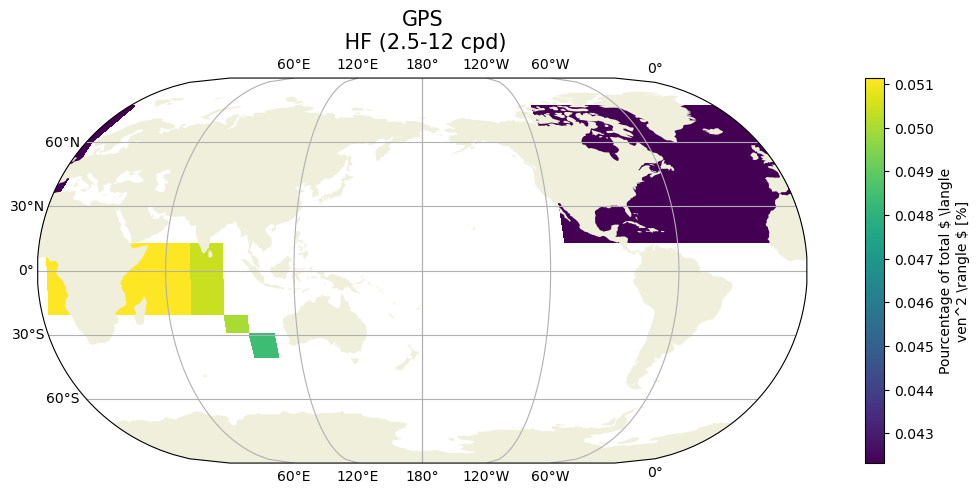

In [25]:
geo_plot(
    d_h.HF_ven,
    legend=r"Pourcentage of total $ \langle ven^2 \rangle $ [%]",
    title="GPS\n HF (2.5-12 cpd)",
    cmap="viridis",
)

In [32]:
d_h.lon_bins.compute()

<xarray.DataArray 'lon_bins' (lon_bins: 5)>
array([-55.,  61.,  81.,  91., 103.])
Coordinates:
  * lon_bins  (lon_bins) float64 -55.0 61.0 81.0 91.0 103.0

In [33]:
d_h.lat_bins.compute()

<xarray.DataArray 'lat_bins' (lat_bins: 4)>
array([-35., -23., -19.,  45.])
Coordinates:
  * lat_bins  (lat_bins) float64 -35.0 -23.0 -19.0 45.0

In [34]:
d_h.HF_ven.compute()

<xarray.DataArray 'HF_ven' (lon_bins: 5, lat_bins: 4)>
array([[       nan,        nan,        nan, 0.04232294],
       [       nan,        nan, 0.05113789,        nan],
       [       nan,        nan, 0.05038877,        nan],
       [       nan, 0.04999859,        nan,        nan],
       [0.04837487,        nan,        nan,        nan]])
Coordinates:
  * lat_bins  (lat_bins) float64 -35.0 -23.0 -19.0 45.0
  * lon_bins  (lon_bins) float64 -55.0 61.0 81.0 91.0 103.0

In [23]:
_tuple_h = np.argwhere(~np.isnan(np.array(d_h.HF_ven)))
_tuple_normal = np.argwhere(~np.isnan(np.array(d_normal.HF_ven)))

In [26]:
_tuple_h

array([[0, 3],
       [1, 2],
       [2, 2],
       [3, 1],
       [4, 0]])

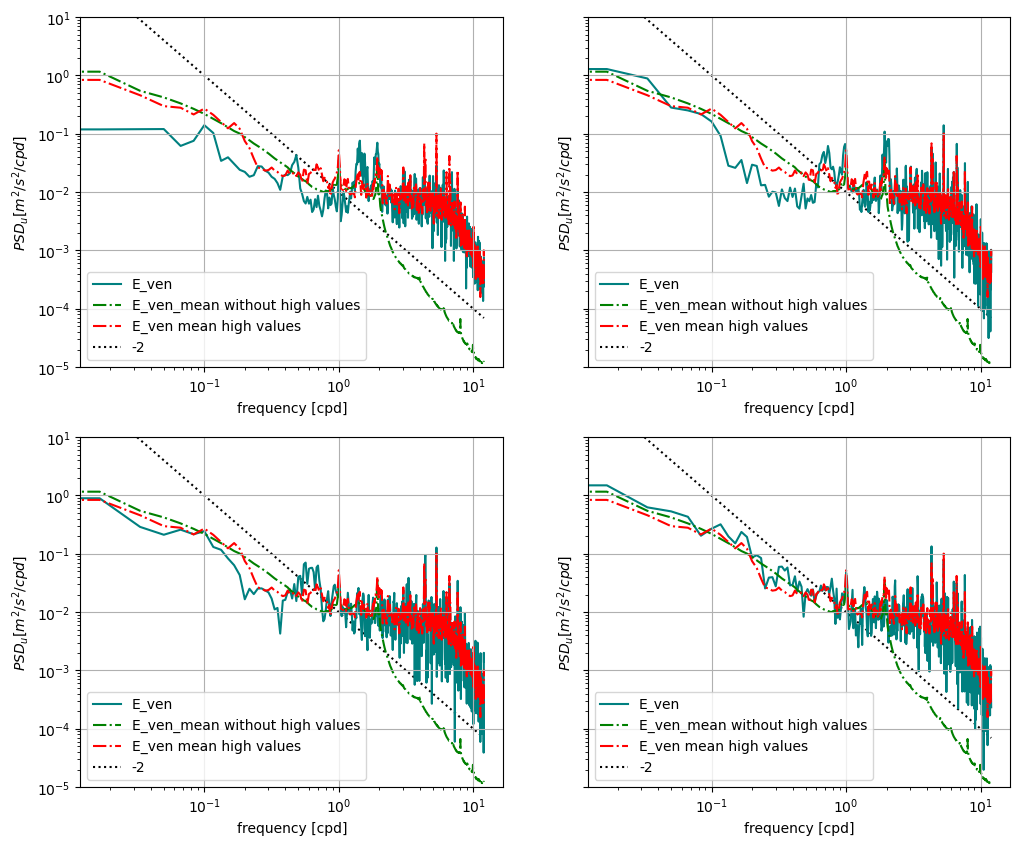

In [28]:
# CHOOSE BIN HERE
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(12, 10))
ax = ax.flatten()

i = 0
for i in range(0, 4):
    tle = _tuple_h[i]
    lon = tle[0]
    lat = tle[1]

    d_h.E_ven.isel(lon_bins=lon, lat_bins=lat).plot(
        label="E_ven", color="teal", ax=ax[i], zorder=1
    )
    d_normal.mean(["lon_bins", "lat_bins"]).E_ven.plot(
        label="E_ven_mean without high values", color="g", ls="-.", ax=ax[i], zorder=1
    )
    d_h.mean(["lon_bins", "lat_bins"]).E_ven.plot(
        label="E_ven mean high values", color="r", ls="-.", ax=ax[i], zorder=1
    )
for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / d_h.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color="k", zorder=0)
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls=":", color = 'grey')
    a.set_ylim((1e-5, 1e1))
    a.set_ylabel(r"$PSD_u [m^2/s^2/cpd]$")
    a.legend()

# ax[i].set_title(f"GPS (nb = {int(d_h.nb_geobins.isel(lon_bins=lon, lat_bins=lat).values)})")
# ax[1].set_title(f"Argos (nb = {int(d_h.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})")

# fig.suptitle(f'lon={lon}, lat={lat}')

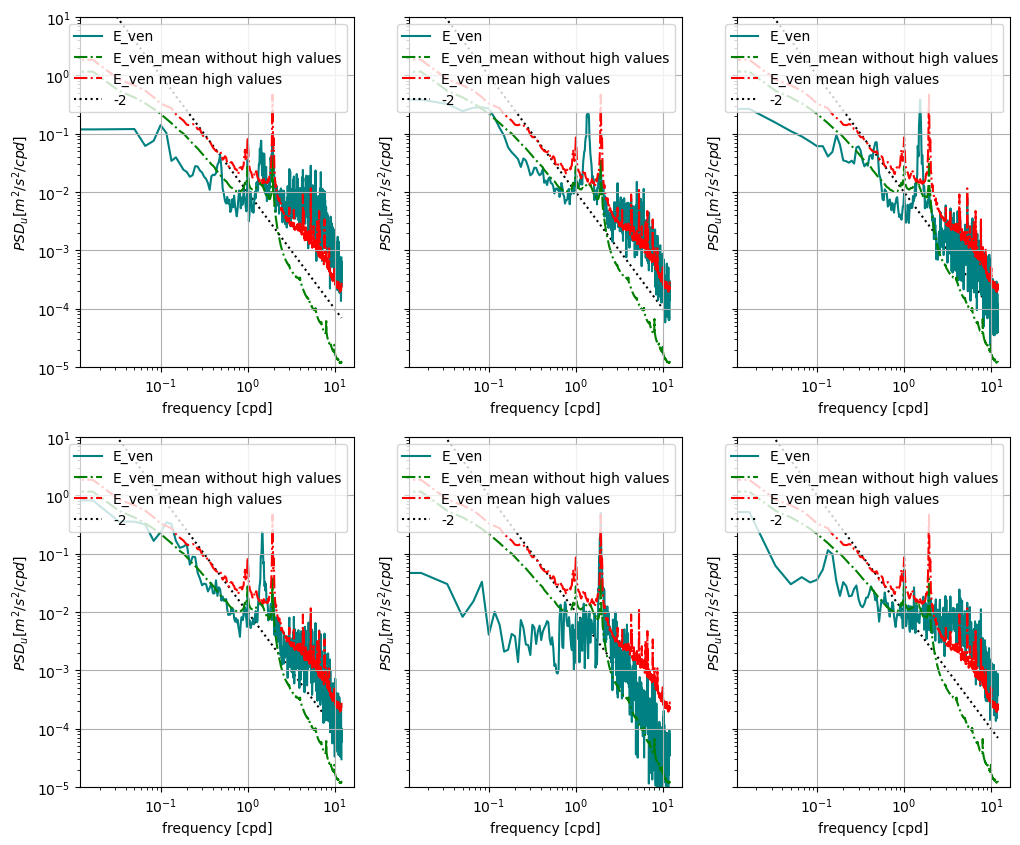

In [23]:
# CHOOSE BIN HERE
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(12, 10))
ax = ax.flatten()

i = 0
for i in range(0, 6):
    tle = _tuple_h[i + 30]
    lon = tle[0]
    lat = tle[1]

    d_h.E_ven.isel(lon_bins=lon, lat_bins=lat).plot(
        label="E_ven", color="teal", ax=ax[i], zorder=1
    )
    d_normal.mean(["lon_bins", "lat_bins"]).E_ven.plot(
        label="E_ven_mean without high values", color="g", ls="-.", ax=ax[i], zorder=1
    )
    d_h.mean(["lon_bins", "lat_bins"]).E_ven.plot(
        label="E_ven mean high values", color="r", ls="-.", ax=ax[i], zorder=1
    )
for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / d_h.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color="k", zorder=0)
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls=":", color = 'grey')
    a.set_ylim((1e-5, 1e1))
    a.set_ylabel(r"$PSD_u [m^2/s^2/cpd]$")
    a.legend()

# ax[i].set_title(f"GPS (nb = {int(d_h.nb_geobins.isel(lon_bins=lon, lat_bins=lat).values)})")
# ax[1].set_title(f"Argos (nb = {int(d_h.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})")

# fig.suptitle(f'lon={lon}, lat={lat}')

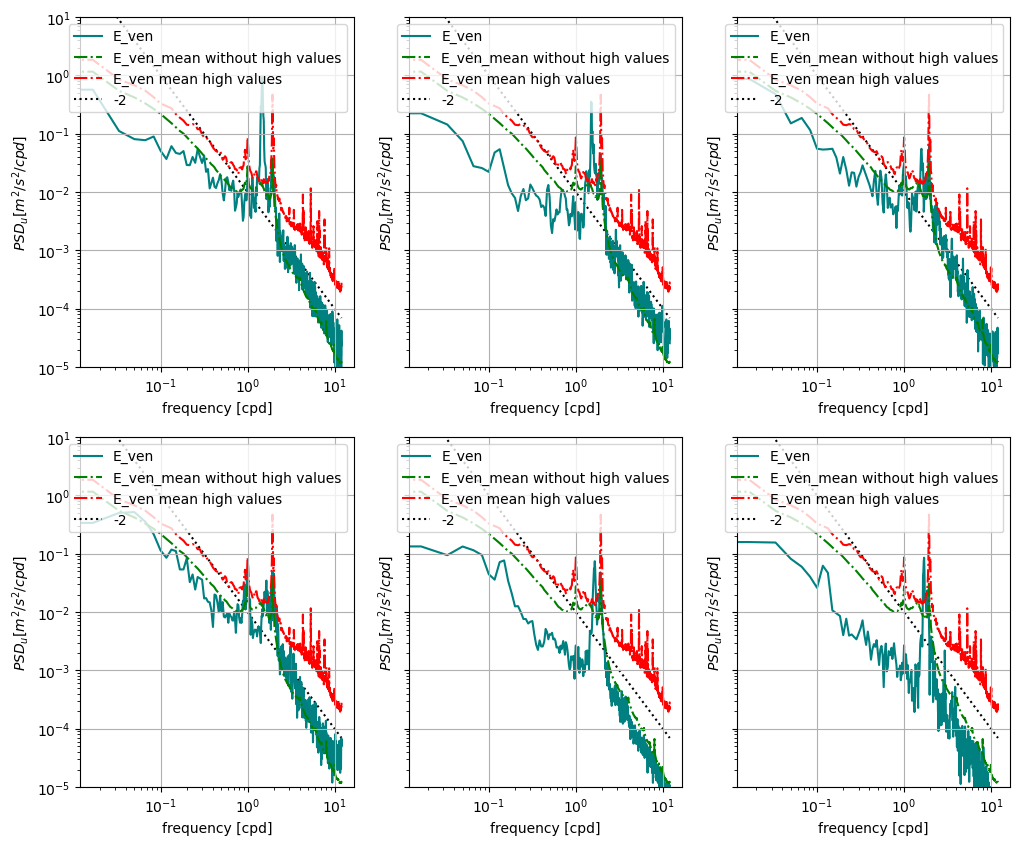

In [26]:
# CHOOSE BIN HERE
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(12, 10))
ax = ax.flatten()

i = 0
for i in range(0, 6):
    tle = _tuple_normal[i + 50]
    lon = tle[0]
    lat = tle[1]

    d_normal.E_ven.isel(lon_bins=lon, lat_bins=lat).plot(
        label="E_ven", color="teal", ax=ax[i], zorder=1
    )
    d_normal.mean(["lon_bins", "lat_bins"]).E_ven.plot(
        label="E_ven_mean without high values", color="g", ls="-.", ax=ax[i], zorder=1
    )
    d_h.mean(["lon_bins", "lat_bins"]).E_ven.plot(
        label="E_ven mean high values", color="r", ls="-.", ax=ax[i], zorder=1
    )
for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / d_h.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color="k", zorder=0)
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls=":", color = 'grey')
    a.set_ylim((1e-5, 1e1))
    a.set_ylabel(r"$PSD_u [m^2/s^2/cpd]$")
    a.legend()

# ax[i].set_title(f"GPS (nb = {int(d_h.nb_geobins.isel(lon_bins=lon, lat_bins=lat).values)})")
# ax[1].set_title(f"Argos (nb = {int(d_h.nb_geobins.sel(lon_bins=lon, lat_bins=lat, method='nearest').values)})")

# fig.suptitle(f'lon={lon}, lat={lat}')

In [35]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

In [36]:
cluster.close()